## Triangulating to the data distribution

There are two free parameters in the variable-triangulation / binning notebook and these should be 
determined in some manner to provide the best confidence in the resulting interpolation (or a range
of acceptable interpolations).

The approach we use is to subdivide the data into random sets - a large one to build the model and 
a smaller one to test the model.

The meshes are all built assuming the locations of all the data. When data points are dropped, the
weighting of the bins will change and some points will become underconstrained. 

This is all useful information and can be used to estimate the sensitivity of the prediction to the
parameters in the model (next notebook).

In [1]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import litho1pt0

import gdal

In [2]:
## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True, refinement_levels=4, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

grid1 = stripy.sTriangulation(grid1r.lons_map_to_wrapped(grid1r.lons[nodes])%(2.0*np.pi), grid1r.lats[nodes], permute=True)


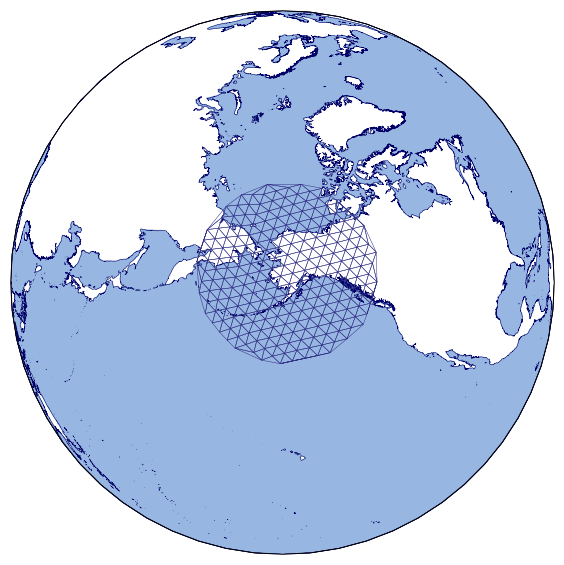

In [3]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=-160, central_latitude=60))
# ax  = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-160))

ax.set_extent([-175,-130,50,72])
ax.set_global()
global_extent = [-180,180,-90,90]

grid = grid1

ax.coastlines(resolution="10m",color="#000066", linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN)


lons0 = np.degrees(grid.lons)
lats0 = np.degrees(grid.lats)

## Triangulation

for tri in grid1.simplices: 
    ax.plot( [lons0[tri[0]], lons0[tri[1]], lons0[tri[2]], lons0[tri[0]]],
             [lats0[tri[0]], lats0[tri[1]], lats0[tri[2]], lats0[tri[0]]],
             linewidth=0.5,
             color="#333388", transform=ccrs.PlateCarree(), zorder=2 )


In [4]:
## Assuming the previous notebook was run, read in the data ...

data = np.load("AlaskaMoho.npz")
moho_data_all = data['alaska_moho']

datagrid = stripy.sTriangulation(np.radians(moho_data_all['lon']),
                                 np.radians(moho_data_all['lat']), 
                                 permute=True, tree=False)


In [5]:
targets_p1 = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13, 15, 20, 30]
targets_p2 = [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## Build several triangulations for testing

Let $p_1$ be the free parameter (the target nodal weight) for the mesh and obtain meshes for a range of values of this parameter 



In [6]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):
    
    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!
    
    for i in range(0, len(data)):
        

        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        

    grid[np.where(norm > 0.0)] /= norm[np.where(norm > 0.0)]
    
    return grid, norm, count

In [7]:
def refine_grid_to_target_points(lons, lats, grid1, target_value ):

    grids = [grid1]
    
    target = target_value

    for i in range(0, 20):

        ## First refine

        ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grids[-1])

        node_area = np.zeros(grids[-1].npoints)
        t_areas = grids[-1].areas()

        for t,simplex in enumerate(grids[-1].simplices):
            node_area[simplex] += t_areas[t] 

        node_area /= node_area.max()

        ## Conditions on weighted average & min area 
        
        vertices = np.where(np.logical_and(norm > target, node_area > 0.0001))[0]

        if vertices.shape[0] != 0: 
            newlons, newlats = grids[-1].centroid_refine_triangulation_by_vertices(vertices=vertices)
            rgrid = stripy.sTriangulation(newlons, newlats, permute=False)
            grids.append(rgrid)

        else:        
            break

    # Needs a final update 
    ave, norm, count = weighted_average_to_nodes(np.radians(lons), np.radians(lats), np.ones_like(lats), grids[-1])
    return grids[-1], norm


## Build grids for each target p1 value

adapted_grids = {}
grid_norm = {}

for p1 in targets_p1:
    adapted_grids[p1], grid_norm[p1] = refine_grid_to_target_points(moho_data_all['lon'], moho_data_all['lat'], grid1, p1)
    print("Grid for {} has {} points".format(p1, adapted_grids[p1].npoints))
    
    

Grid for 3.0 has 627 points
Grid for 4.0 has 490 points
Grid for 5.0 has 442 points
Grid for 6.0 has 403 points
Grid for 7.0 has 364 points
Grid for 8.0 has 347 points
Grid for 9.0 has 330 points
Grid for 10.0 has 299 points
Grid for 11.0 has 296 points
Grid for 13 has 282 points
Grid for 15 has 276 points
Grid for 20 has 253 points
Grid for 30 has 248 points


In [8]:
## This is a smooth version of the gridded data - the smoothing operator is taken from ssrfpack 
## The weights indicate the confidence in the data. For points that have few constraints, the weight 
## might well be lower but, perhaps, the variance should also play a role ... 

def compute_smoothed_solutions(goodgrid, gnorm, weight, data, a1):

    weights = 0.001 + gnorm
    ave = data

    smooth_d = goodgrid.smoothing(ave, weights, a1*goodgrid.npoints, 0.5, 0.001)

    return smooth_d


In [9]:
def partition_data(val=0.8):
    
    test = np.random.random(moho_data_all.shape[0]) > val
    training = ~test

    moho_data = moho_data_all[training]
    moho_data_test = moho_data_all[test]

    return moho_data, moho_data_test

In [10]:
def data_model(p1, p2, moho_data, moho_data_test):
    """
    p1 -> target parameter in adaptive triangulation
    p2 -> smoothing parameter (should be a list / array as this does not require re-triangulation)
    """
    
    import litho1pt0
    
    grid = adapted_grids[p1]
 
    ## This information all changes when the data is subsampled
    ave, gnorm, count = weighted_average_to_nodes(np.radians(moho_data['lon']), 
                                                  np.radians(moho_data['lat']), 
                                                  moho_data['moh'], grid)

    ## If we have no information for a location in the grid for this partitioning of the
    ## data, then we fill from litho 1.0 - the weight associated with these points
    ## is low and should not influence the surrounding values

    unconstrained_locations = np.where(gnorm == 0.0)
    unknown_lons_deg = np.degrees(grid.lons[unconstrained_locations])%360.0
    unknown_lats_deg = np.degrees(grid.lats[unconstrained_locations])

    c2 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="LID-TOP")
    c1 = litho1pt0.layer_depth(lon=unknown_lons_deg, lat=unknown_lats_deg, layerID="CRUST1-TOP")

    ave[unconstrained_locations] = (c2-c1) * 0.001 ## Convert to km
    

    error, xxx = datagrid.interpolate(grid.lons, grid.lats, moho_data_all['mean_err'],order=1)
    enorm = 1.0 / error
        
    try:
        predictor, deriv = compute_smoothed_solutions(grid, enorm, 1.0, ave, p2)
        failed = 0
    except:
        print("Cannot compute accurate smooth solution for p1 = {}, p2 = {}".format(p1, p2))
        predictor, deriv = compute_smoothed_solutions(grid, enorm, 1.0, ave, 0.0001)
        failed = 1


    
    ## This is a measure of how well the model fits the test data points
    
    smooth_data_prediction, e0 = grid.interpolate(np.radians(moho_data_test['lon']),
                                                   np.radians(moho_data_test['lat']), 
                                                   predictor) 
    
    err = np.sqrt(((smooth_data_prediction - moho_data_test['moh'])**2).sum() / moho_data_test.shape[0])
    
        
    ## This is a measure of how well the model fits the points that it fits
    

    smooth_data_reconstruction, e0 = grid.interpolate(np.radians(moho_data['lon']),
                                                        np.radians(moho_data['lat']), predictor)
    
    err1 = np.sqrt(((smooth_data_reconstruction - moho_data['moh'])**2).sum() / moho_data.shape[0])


    if not failed:
        return err, err1, err / err1, predictor, deriv
    else:
        return err, -err1, err / err1, predictor, deriv




In [11]:

## Make a partitioning of the data, then save the error information for each triangulation / smoother setting. 

loops = 500

## Find the best p1, p2 for each bisection of the data


err1 = np.zeros((loops, len(targets_p1), len(targets_p2)))
err2 = np.zeros((loops, len(targets_p1), len(targets_p2)))
errR = np.zeros((loops, len(targets_p1), len(targets_p2)))

for e in range(0,loops):
    
    print "Partioning no ", e
    moho_data, moho_data_test = partition_data(np.random.random()*0.2+0.75)

    for i, target_p1 in enumerate(targets_p1):
        for j, target_p2 in enumerate(targets_p2):
            
            # print e, i, j 
     
            e1, e2, eR, predictor, deriv = data_model(target_p1, target_p2, moho_data, moho_data_test)
            err1[e,i,j] = e1
            err2[e,i,j] = e2
            errR[e,i,j] = eR
        
        

Partioning no  0
Partioning no  1
Partioning no  2
Partioning no  3
Partioning no  4
Partioning no  5
Partioning no  6
Partioning no  7
Partioning no  8
Partioning no  9
Partioning no  10
Partioning no  11
Partioning no  12
Partioning no  13
Partioning no  14
Partioning no  15
Partioning no  16
Partioning no  17
Partioning no  18
Partioning no  19
Partioning no  20
Partioning no  21
Partioning no  22
Partioning no  23
Partioning no  24
Partioning no  25
Partioning no  26
Partioning no  27
Partioning no  28
Partioning no  29
Partioning no  30
Partioning no  31
Partioning no  32
Partioning no  33
Partioning no  34
Partioning no  35
Partioning no  36
Partioning no  37
Partioning no  38
Partioning no  39
Partioning no  40
Partioning no  41
Partioning no  42
Partioning no  43
Partioning no  44
Partioning no  45
Partioning no  46
Partioning no  47
Partioning no  48
Partioning no  49
Partioning no  50
Partioning no  51
Partioning no  52
Partioning no  53
Partioning no  54
Partioning no  55
Pa

Partioning no  437
Partioning no  438
Partioning no  439
Partioning no  440
Partioning no  441
Partioning no  442
Partioning no  443
Partioning no  444
Partioning no  445
Partioning no  446
Partioning no  447
Partioning no  448
Partioning no  449
Partioning no  450
Partioning no  451
Partioning no  452
Partioning no  453
Partioning no  454
Partioning no  455
Partioning no  456
Partioning no  457
Partioning no  458
Partioning no  459
Partioning no  460
Partioning no  461
Partioning no  462
Partioning no  463
Partioning no  464
Partioning no  465
Partioning no  466
Partioning no  467
Partioning no  468
Partioning no  469
Partioning no  470
Partioning no  471
Partioning no  472
Partioning no  473
Partioning no  474
Partioning no  475
Partioning no  476
Partioning no  477
Partioning no  478
Partioning no  479
Partioning no  480
Partioning no  481
Partioning no  482
Partioning no  483
Partioning no  484
Partioning no  485
Partioning no  486
Partioning no  487
Partioning no  488
Partioning n

In [12]:
## Statistics on these meshes

err1m = err1.mean(axis=0)
err2m = err2.mean(axis=0)

err1c = err1.copy()
err1c[err2 < 0.0] = err1c.max()
err1c.sort(axis=0)

errSm = err1m.copy()
errSm[err2m < 0.0] = err1m.max()

med1   = err1c[err1c.shape[0]/2,:,:]
uqart1 = err1c[err1c.shape[0]/4,:,:]

var1  = ((err1c - errSm)**2).mean(axis=0)

print targets_p1
print targets_p2
# print var1
print errSm.min()
print uqart1.min(), med1.min(), err1m.min()
print var1.min(), var1.max()

[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13, 15, 20, 30]
[0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
7.0026719034847025
6.476632087298447 6.995744364928857 7.0026719034847025
0.6293033846868845 0.8993981889422751


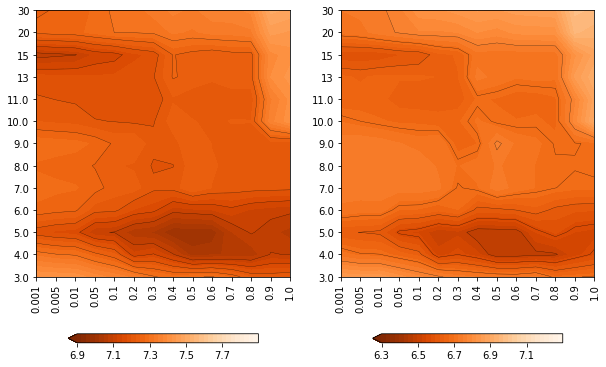

In [13]:

fig = plt.figure(figsize=(10, 7), facecolor=None)

ax1  = plt.subplot(121)
plt.xticks(np.arange(len(targets_p2)), targets_p2, rotation=90.0)
plt.yticks(np.arange(len(targets_p1)), targets_p1, rotation=0.0)
m1 = ax1.contourf(errSm, cmap=plt.cm.Oranges_r, extend='min',
                  levels = np.linspace(6.9, 7.9, 41))

ax1.contour(errSm, levels = np.linspace(7.1,7.3,5), 
            colors="Black", linewidths=0.25 )

plt.colorbar(mappable=m1, ax=ax1, shrink=0.75,
             ticks=[6.9, 7.1, 7.3, 7.5, 7.7],
             orientation='horizontal')

ax2  = plt.subplot(122)
plt.xticks(np.arange(len(targets_p2)), targets_p2, rotation=90.0)
plt.yticks(np.arange(len(targets_p1)), targets_p1, rotation=0.0)
m2 = ax2.contourf(uqart1, cmap=plt.cm.Oranges_r, extend='min',
                  levels = np.linspace(6.3, 7.3, 41))

ax2.contour(uqart1, levels = np.linspace(6.5,6.75,5), 
            colors="Black", linewidths=0.25 )


plt.colorbar(mappable=m2, ax=ax2, shrink=0.75,
             ticks=[6.3, 6.5, 6.7, 6.9, 7.1],
            orientation='horizontal')



In [14]:
## A selection of results that are close to the best one

## Note the mean / median / upper quartile selections are the same

optps = np.argwhere(err1m <  1.01 * (err1m).min())

print optps.shape[0]

one_percenters = []

for e in range (0,optps.shape[0]):
    print targets_p1[optps[e][0]],targets_p2[optps[e][1]], \
          err1m[optps[e][0], optps[e][1]], \
          err2m[optps[e][0], optps[e][1]]
    one_percenters.append((targets_p1[optps[e][0]],targets_p2[optps[e][1]]))

        

optps = np.argwhere(med1 < 1.01 *  med1.min())

print optps.shape[0]

for e in range (0,optps.shape[0]):
    print targets_p1[optps[e][0]],targets_p2[optps[e][1]], med1[optps[e][0], optps[e][1]]

## Based on the mean_err weighting of the individual points, the best value for p_2 is 0.4
    
best_grid = adapted_grids[5.0]


10
4.0 0.5 7.035241524290867 5.234777675941939
4.0 0.6 7.045162009963495 5.184040397544997
4.0 0.7 7.055016668318448 5.141550133911472
4.0 0.8 7.056869034539904 5.142550782254613
5.0 0.2 7.057965626139118 5.080178804828957
5.0 0.3 7.045299171282779 5.228127129894302
5.0 0.4 7.0026719034847025 5.433765211537778
5.0 0.5 7.005639669059913 5.375333559834693
5.0 0.6 7.007666824142421 5.367472081268901
5.0 1.0 7.065749596259035 5.926976437666447
9
4.0 0.5 7.056438543981757
5.0 0.2 7.058428834817516
5.0 0.3 7.037451919111387
5.0 0.4 6.995744364928857
5.0 0.5 6.999571264715353
5.0 0.6 7.009260316436502
15 0.001 7.042259286186187
15 0.005 7.06002265779608
15 0.01 7.060601648742009


In [15]:
one_percenters

[(4.0, 0.5),
 (4.0, 0.6),
 (4.0, 0.7),
 (4.0, 0.8),
 (5.0, 0.2),
 (5.0, 0.3),
 (5.0, 0.4),
 (5.0, 0.5),
 (5.0, 0.6),
 (5.0, 1.0)]

In [16]:
## Plot the best ones ... 

e1,e2,e3, smooth_5_04, deriv_05_04 = data_model(5.0,0.4, moho_data_all, moho_data_all)

e1,e2,e3, smooth_5_08, deriv_5_08 = data_model(5.0,0.8, moho_data_all, moho_data_all)

e1,e2,e3, smooth_15_001, deriv_15_001 = data_model(15.0,0.001, moho_data_all, moho_data_all)


best_smoothing_val = 0.4
best_smoother = smooth_5_04
best_smoother_dds = deriv_05_04

In [17]:
## Map everything to a regular triangulation for plotting and to demonstrate how interpolation works.

## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, refinement_levels=8, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

lons1 = grid1r.lons[nodes]%(2.0*np.pi)
lats1 = grid1r.lats[nodes]

# identify points within X degrees of a data point

grid1 = stripy.sTriangulation(np.radians(moho_data_all['lon']), np.radians(moho_data_all['lat']), tree=True)
near_nodes, distances = grid1.nearest_vertex(lons1, lats1) 
nodes = np.where(distances < 0.075)[0]

# # Now identify points within triangles

# i, err = datagrid.interpolate(lons1, lats1, np.ones_like(datagrid.lons))
# nodes = np.where(err==0)

gridF = stripy.sTriangulation(lons1[nodes]%(2.0*np.pi), lats1[nodes], permute=True)

# Use this as a quality measure 

distances_k, near_nodes = grid1.nearest_vertices(gridF.lons, gridF.lats, k=5) 
distances = distances_k.mean(axis=1)
interpolation_quality_d = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())

distances_k, near_nodes = grid1.nearest_vertices(gridF.lons, gridF.lats, k=5) 
distances = distances_k.mean(axis=1)
interpolation_quality_d2 = np.maximum(0.0, 1.0 - 2.0*distances / distances.mean())

distances_k, near_nodes = grid1.nearest_vertices(best_grid.lons, best_grid.lats, k=5) 
distances = distances_k.mean(axis=1)
interpolation_quality_optg = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())



In [18]:
gridF_interpolation_5_04, err   = adapted_grids[5.0].interpolate(gridF.lons, gridF.lats, smooth_5_04, order=3)
gridF_interpolation_5_08, err   = adapted_grids[5.0].interpolate(gridF.lons, gridF.lats, smooth_5_08, order=3)
gridF_interpolation_15_001, err = adapted_grids[15.0].interpolate(gridF.lons, gridF.lats, smooth_15_001, order=3)

gridF_opc    = np.zeros_like(gridF.lons)
gridF_opc_sl = np.zeros_like(gridF.lons)


for opc in one_percenters:
    
    e1,e2,e3, smooth, deriv = data_model(opc[0],opc[1], moho_data_all, moho_data_all)
    interp, err = adapted_grids[opc[0]].interpolate(gridF.lons, gridF.lats, smooth, order=3)
    
    slope = np.hypot(deriv[0], deriv[1], deriv[2])
    nval, gnorm, count = weighted_average_to_nodes(datagrid.lons, datagrid.lats, np.ones_like(datagrid.lats), adapted_grids[opc[0]])
    slope[gnorm==0] = 0.0
    
    interps, err = adapted_grids[opc[0]].interpolate(gridF.lons, gridF.lats, slope, order=1)

    gridF_opc    += interp
    gridF_opc_sl += interps
    
gridF_opc    /= len(one_percenters)
gridF_opc_sl /= len(one_percenters)

In [59]:
## Use gmt colour palette

import pycpt

cptdict = pycpt.load.find_cpt_files("cpt")

msmcmap  = pycpt.load.gmtColormap("cpt/moho_20-40km.cpt")
msmcmap2 = pycpt.load.gmtColormap("cpt/moho_dry-wet.cpt")


<function pycpt.display.demo_gmt>

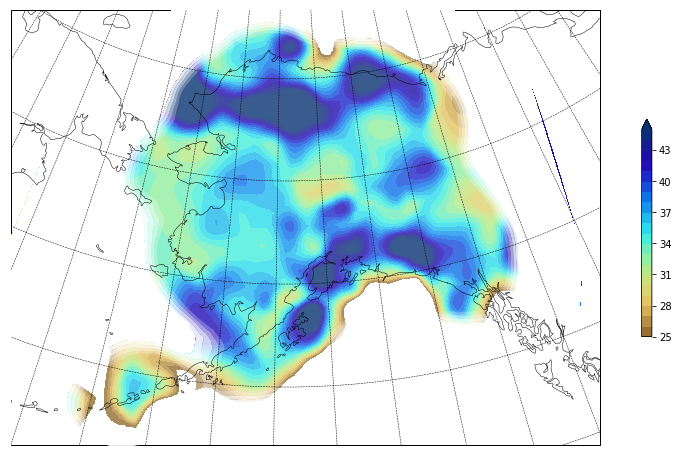

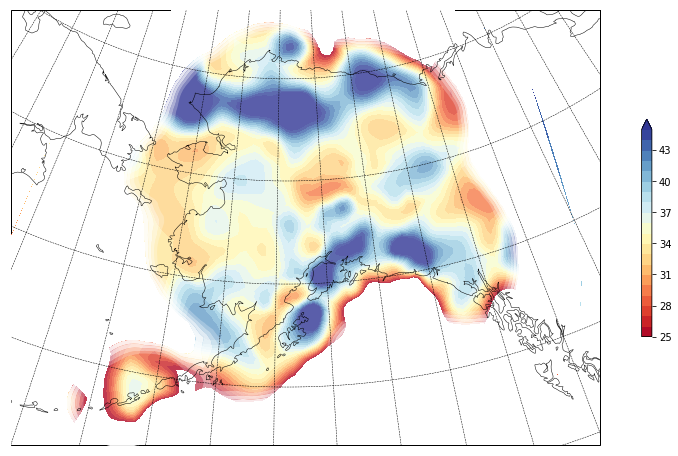

In [52]:
def alaska_plot2(filename, grid, data, quality, plot_range=[25.0, 50.0], cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-175,-130,50,72])
    
    
    grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m",
                                           name="graticules_5")
    
    ax1.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=98)
    ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=99)



    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, grid_data, 
                   cmap=cmap, alpha=1.0, levels=np.linspace(plot_range[0], plot_range[1], 21),
                   extend="max", linewidths=10.0,
                   transform=ccrs.PlateCarree(), zorder=5)
    
    ## Mask by "quality" of the interpolation
    
    cnt1 = ax1.tricontourf(lons, lats, goodgrid.simplices, interpolation_quality, 
                       levels=[ -100, 0.05, 0.1, 0.15, 0.2, 0.25, 1.0],
                       colors=[(1.0,1.0,1.0,1.0), (1.0,1.0,1.0,0.9),
                               (1.0,1.0,1.0,0.8), (1.0,1.0,1.0,0.6),
                               (1.0,1.0,1.0,0.4),(1.0,1.0,1.0,0.2),
                               (1.0,1.0,1.0,0.0)], extend="both",
                       linewidths=0.0,
                       transform=ccrs.PlateCarree(), 
                       zorder=10)  
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt1.collections:
        c.set_edgecolor("#00000000")
        c.set_linewidth(0.0)

    ## Locations of raw data collection

#     m = ax1.scatter(moho_data['lon'], moho_data['lat'],  color="Black",
#                    edgecolor="Black", linewidth=0.5, 
#                    marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

    from PIL import ImageChops
    from PIL import Image
    import io, os
    
    filename_base, filename_ext = os.path.splitext(filename)

    im_buffer = io.BytesIO()
    fig.savefig(im_buffer, format='png', dpi=600)
    
    im_buffer.seek(0)
    im = Image.open(im_buffer)

    imbg = Image.open("AlaskaMohoImgBg.png")
    imblend = ImageChops.multiply(imbg,im)
    imblend.save("{}+bg.png".format(filename_base))
    im_buffer.close()

    ax1.imshow(imblend)
    
       
    
alaska_plot2("gridF_optV_5_04.png", gridF, gridF_interpolation_5_04, 
            interpolation_quality_d, plot_range=[25, 45], cmap=msmcmap2)

alaska_plot2("gridF_one_percent.png", gridF, gridF_opc, 
            interpolation_quality_d, plot_range=[25, 45], cmap=plt.cm.RdYlBu)



# alaska_plot2("gridF_optV_15_001.png", gridF, gridF_interpolation_15_001, 
#             interpolation_quality_d, plot_range=[25, 50], cmap=plt.cm.YlGnBu)

# alaska_plot2("gridF_optV_5_08.png", gridF, gridF_interpolation_5_08, 
#             interpolation_quality_d, plot_range=[25, 50], cmap=plt.cm.YlGnBu)






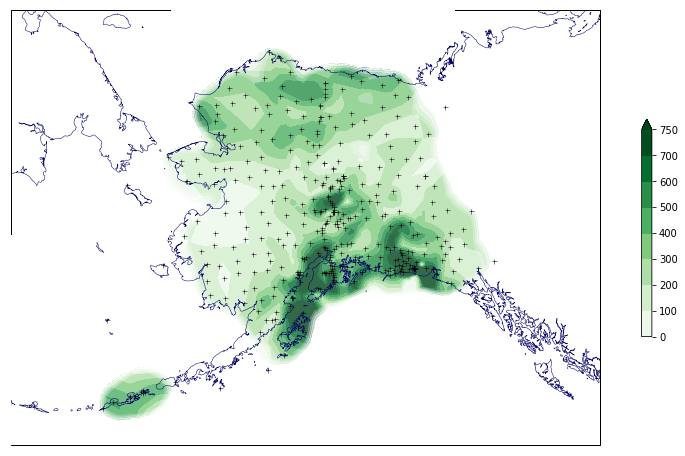

In [50]:
def alaska_moho_slope_plot(filename, grid, data, quality, 
                           plot_range=[25.0, 50.0], cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-175,-130,50,72])
    ax1.coastlines(resolution="10m",color="#000066", linewidth=0.5, zorder=99)

    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    
    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, grid_data, 
                   cmap=cmap, alpha=1.0, 
                   levels=[0.0, 100, 200, 300, 400, 500, 600, 700, 750],
                   # levels=[0.0, 0.1, 0.2, 0.5, 1.0],
                   extend="max", linewidths=10.0,
                   transform=ccrs.PlateCarree(), zorder=0)
    
    ## Mask by "quality" of the interpolation
    
    cnt1 = ax1.tricontourf(lons, lats, goodgrid.simplices, interpolation_quality, 
                       levels=[ -100, 0.05, 0.1, 0.15, 0.2, 0.25, 1.0],
                       colors=[(1.0,1.0,1.0,1.0), (1.0,1.0,1.0,0.9),
                               (1.0,1.0,1.0,0.8), (1.0,1.0,1.0,0.6),
                               (1.0,1.0,1.0,0.4),(1.0,1.0,1.0,0.2),
                               (1.0,1.0,1.0,0.0)], extend="both",
                       linewidths=0.0,
                       transform=ccrs.PlateCarree(), 
                       zorder=10)  
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt1.collections:
        c.set_edgecolor("#00000000")
        c.set_linewidth(0.0)

    ## Locations of raw data collection

    m = ax1.scatter(moho_data_all['lon'], moho_data_all['lat'],  color="Black",
                   edgecolor="Black", linewidth=0.5, 
                   marker="+", s=25.0, transform=ccrs.Geodetic(), zorder=25)


    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, drawedges=False )

    from PIL import ImageChops
    from PIL import Image
    import io, os
    
    filename_base, filename_ext = os.path.splitext(filename)

    im_buffer = io.BytesIO()
    fig.savefig(im_buffer, format='png', dpi=600)
    
    im_buffer.seek(0)
    im = Image.open(im_buffer)

    imbg = Image.open("AlaskaMohoImgBg.png")
    imblend = ImageChops.multiply(imbg,im)
    imblend.save("{}+bg.png".format(filename_base))
    im_buffer.close()

    ax1.imshow(imblend)
    
    
    return

alaska_moho_slope_plot("AlaskaMohoSlope_OPC", gridF, gridF_opc_sl, 
            interpolation_quality_d2, plot_range=[0, 1000.0], cmap=plt.cm.Greens)




In [21]:
## Write the preferred model grid data / parameters to a file for re-use


In [30]:
np.savez("AlaskaMohoGridded", 
         gridlons=best_grid.lons, 
         gridlats=best_grid.lats, 
         smoothed_data=best_smoother,
         derivatives=best_smoother_dds,
         quality=interpolation_quality_optg)

In [23]:
## Also save the ensemble ... 

## Create a dictionary 

